# Crash Course in Machine Learning

**Level:** Coding from scratch, including *math*. As low as we're getting.

**Goals:** The take-aways from this notebook are:
1. Understand what a *loss function*'s purpose is and what makes a good one.
2. Learn the simplest form of *gradient descent* and how optimizes a loss function.
2. Implement the gradient descent algorithm in PyTorch.
3. Learn the very basics around improving machine learning models, including batches and what overfitting is.


**Sources:** These notes are based on [this notebook](https://www.kaggle.com/code/jhoward/how-does-a-neural-net-really-work) and [Chapter 4 of the Fastai](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb) book.

## Sections in this Notebook
* [Supervised Learning: The General Problem](#scrollTo=fKZpKdCfdRZu)
* [Loss Functions](#scrollTo=vX8x9zk5ojG6)
* [Gradient Descent](#scrollTo=z1FXIKRSsYtm)
* [Stochastic and Mini-Batch Gradient Descent](#scrollTo=q_rMmZE_IMXg)
* [Intro to Overfitting](#scrollTo=eZVVQorLyCs9)

## Vocab Terms:

* **batch.** Most models don't work with the entire training set at once, but split it into multiple mini-batches. This cuts down how much memory is needed to do the training, and overall generally speeds the process up.

* **cost/loss function.** The *cost function* tells you how wrong your model is for one observation in your dataset. $(y-\hat{y})^2$ is a common one. The *loss function* is the average cost over the entire training set.

* **epoch.** When you have looped over the entire training dataset while training a model, one *epoch* has been completed.

* **gradient descent.** A method for optimizing functions by following them "downhill." We'll be using gradient descent on the loss function to find the best possible *parameters* for our *models*.

* **hyperparameters.** A list of inputs to the model that are chosen by the data scientist and are *not* changed at training time. The learning rate and decay are examples of hyperparameters.

* **inputs, independent variables, $x$ variables, predictors.** These are the variables we use to predict an output. It could be some text, a photograph, measurements in a spreadsheet. In a line model, $\hat{y} = mx+b$, the input is literally the $x$.

* **machine learning.** An approach to fitting models to data by using an algorithm to iterate toward the best parameters. Machine learning is generally concerned with doing a good job of predicting the value of $y$, but is not concerned with where $y$ really comes from. This can be contrasted with *statistics*, which works with precise, exactly solvable models.

* **model.** A general mathematical function which predicts values of the output *y* from some given inputs *x*. Most models have *parameters* that need to be fit before they are useful. The equation $\hat{y} = mx + b$ is the model for a line.

* **outputs, dependent variables, $y$ variables, response.** These are the things we want to predict. It could be whether a review is positive or negative, how much money we'll make, or whether a photograph is a picture of a cat or a dog. In a line model, $\hat{y} = mx+b$, the output is literally $y$.

* **overfitting.** A problem caused by allowing a model to "memorize" the training set. Overfitting is evident when training error rate is low, but validation is higher, or when validation error is low, and test error is high. Can be solved by increasing the size of the training set, reducing training epochs, or using a simpler model, depending on the exact situation.

* **stochastic/batch/mini-batch gradient descent.** Three different approaches to how many observations in the training set are used to evaluate the loss function at each step in gradient descent. *Stochastic* uses one observation at a time, *batch* uses the entire dataset, and *mini-batch* uses a number somewhere in between. Usually $N_{data} ≫ N_{batch} ≫ 1$. Mini-batch is faster than batch, and also more consistent than stochastic. Often mini-batch gradient descent is just called batch gradient descent or gradient descent, which can beconfusing. Realistically, nobody uses anything else.

* **training/validation/testing set.** Subsets of your overall dataset which are used at different parts of the overall model fitting and evaluation process. Models are *trained* on the training set, and then *evaluated* using the validation set. Final evaluation is done on the *testing set*. *Warning:* many APIs (and your instructor) will sometimes erroneously refer to a validation set as a testing set.

* **parameters.** Changeable values in a model which are independent of the inputs. Sometimes referred to as *weights*. In a line, $\hat{y} = mx + b$, the $m$ and $b$ are parameters and $x$ is the input.

* **weights.** Another term for parameters.


In [ ]:
from ipywidgets import interact
from fastai.basics import *
import torch

# Now we don't need to use plt.show()
%matplotlib inline

# Makes the figure output a bit smaller
plt.rc('figure', dpi=90)

# A helper function to plot generic functions
def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None, xlab=None, ylab=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim is not None: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)
    if xlab is not None: plt.xlabel(xlab)
    if ylab is not None: plt.ylabel(ylab)
    plt.show()

## Supervised Learning: The General Problem

We have some data, $x$, which consists of multiple observations, which we want to use to predict some output $y$. Some examples:

|Type of Data|x|y|
|:---:|:-:|:-:|
|Images|Pictures of animals|Animal Type|
| |Dash cam image, GPS location, current speed|How to turn, speed changes|
|Tabular Data|Info on one person (age, income, zip code, &c.)|Political Affiliation|
| |Patient information|Diagnosis|
|Text|Tweet|Rating (1-5 stars)|
||English document|Same document in French|
|Reinforcement Learning| Current state of a board game | What move to take|

Our challenge is to (1) pick a good model that can predict the $y$ from the $x$, and (2) find the best parameters for that model.

We might choose a line as our model, where $\hat{y} = mx + b$. This model has two parameters: the slope $m$ and the intercept $b$. The value of $x$ and $\hat{y}$ vary for each point, but values of $m$ and $b$ are the same. In the case of machine learning, the machine finds (learns) the parameters.

We'll look at several other classes of models, including neural networks for tabular data, convolutional neural networks (CNNs) for images, recurrent neural networks (RNNs) and transformers for text.

___

*Aside:* In statistics, whether the data actually come from this model or not is important. Is the model in some sense "correct"? This is not important in machine learning. We only care whether the model does a good job making predictions or not.

___

## Worked Example

Here's some data. They don't represent anything in particular. We'll get back to real-world data soon enough. Looking at the plot, what sort of model might be good?


Text(0, 0.5, 'y')

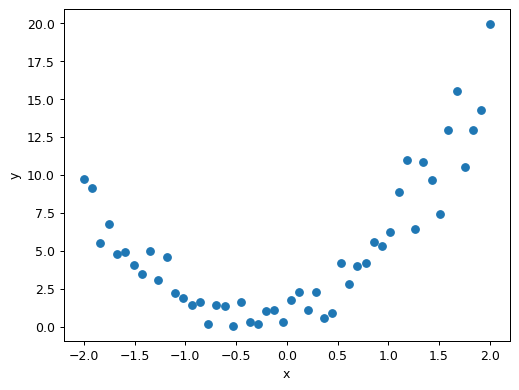

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/Greg-Hallenbeck/class-datasets/main/datasets/ml_sampledata.csv")
x = data["x"]
y = data["y"]

plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")

I think a quadratic might be good. In that case, our model is:
$\hat{y} = ax^2 + bx + c$, with parameters $a$, $b$, and $c$. Let's define a function for this model and plot it. Of course, there's not one single plot for this function. It depends on what the parameters are. If we change the parameters, we get a different plot. The trick is finding the parameters which best fit the data we have.

In [ ]:
def quad(a, b, c, x):
    return a*x**2 + b*x + c

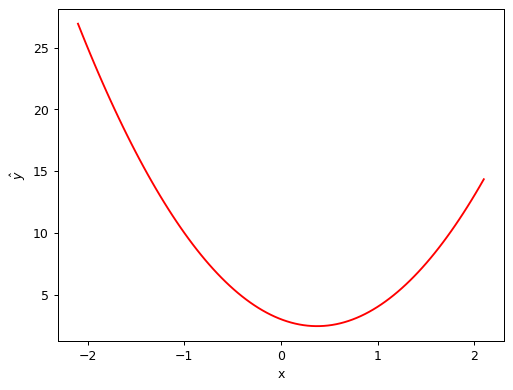

In [ ]:
plot_function(partial(quad,4,-3,3), xlab="x", ylab="$\hat{y}$")


Below is an interactive graph. Take a moment to find the parameters which produce the best fit.

**Q:** How are you determining whether a fit is "good" or "bad"?<br>
**Q:** How would you tell a machine what's good or bad?<br>
**Q:** How are you approaching adjusting the parameters to improve the fit?

In [ ]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    plt.scatter(x,y)
    plot_function(partial(quad, a,b,c), xlab="x", ylab="y")

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

## The Loss Function

The **loss function** is a measure of how bad your model fits your entire dataset. High loss means a bad fit, while low loss means a good fit to your data. We are using it to turn a whole lot of data points, parameters,and a model into a single number to summarize it. Some examples include:

|Name|Math (Single Point)|Python (Single Point) |a.k.a.|Used For|
|:-:|:-:|:-:|:-:|-:|
|Mean Squared Error (MSE)|$(y-\hat{y})^2$|`(y-yhat).pow(2)`|$\text{L}_2$ Loss|Regression|
|Mean Absolute Deviation (MAD)|$|y-\hat{y}|$|`(y-yhat).abs()`|$\text{L}_1$ Loss|Regression|
|Cross-Entropy|$-p\ln\hat{p}$|`p*torch.ln(phat)`|Logistic Loss|Classification|
|Sparse Categorical Cross-Entropy|$-\sum_i p_i \ln \hat{p}_i$|`torch.sum(p*torch.ln(phat))`||Classification|

**Q:** Why would $y-\hat{y}$ be a bad loss function?

As you might imagine, figuring out how to design the loss function is an important step, and choosing a different loss function can get you a different set of final parameters.

In [ ]:
def mse_loss(y, yhat):
    return (y-yhat).pow(2).mean()

Let's add a visual indicator of the loss to the plot above. Take a moment to reflect on the best way to minimize the loss.

In [ ]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    plt.scatter(x,y)

    yhat = quad(a, b, c, x)
    J = mse_loss(y, yhat)

    plot_function(partial(quad, a,b,c), title=f"MSE Loss = {J:0.4}", xlab="x", ylab="y")

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

## Gradient Descent

Our goal is to find a systematic way to teach a computer how to find the minimum of a function.

**Q:** What ways do you know that can be used to find the minimum of a function? Do they work well here?

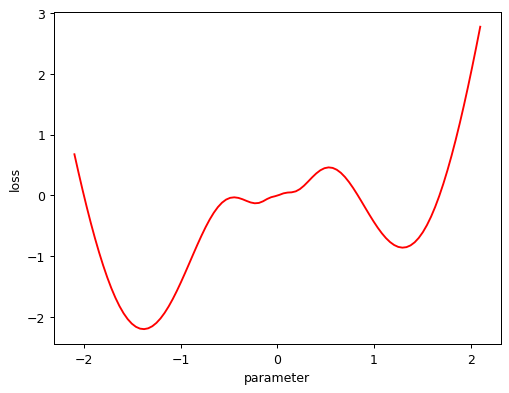

In [ ]:
# An example not very fun function
def f(x):
    return np.sin(np.pi*np.log(abs(4*x)))*np.power(x,2) + 0.5*x

plot_function(f, xlab="parameter", ylab="loss")

We need a method that will allow us to find the minimum of a function without (1) having to solve a complex equation *or* (2) being able to plot the function to look at it.

That second one is actually *very* important, because we need one axis for every parameter in our model. Plotting the loss for our quadric requires a 4 Dimensional plot (3 parameters + the loss!), and we'll be using models that have thousands or hundreds of thousands of parameters. Or we'll have so much data and such a complex model that even making a simple line plot like above for the loss function may take an hour. So let's avoid that!

**Gradient descent** is the way we'll do this. It's quite simple: we choose completely random values for the parameters, then follow the loss downhill. This requires us to only look at the current value of the loss and its gradient (the slope of a function in multiple dimensions). For example, let's say we have this loss that looks like this, and we've chosen a parameter value $A = 1.0$. If we want to get a lower value of the loss, we should decrease $A$.

More rigorously: the slope here is positive, and we want to decrease the value of $A$, so we should *subtract* the slope from $A$.

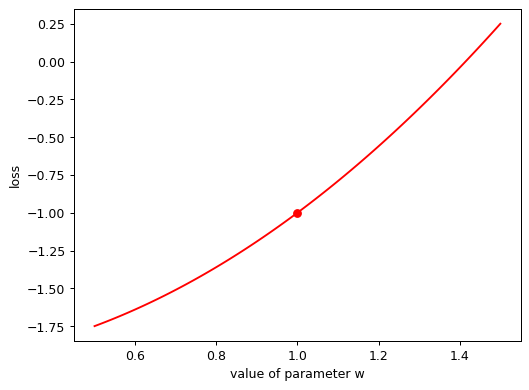

In [ ]:
def f(w):
    return w**2 -2

plt.scatter(1, f(1), color='r')
plot_function(f, min=0.5, max=1.5, xlab="value of parameter w", ylab="loss")

Here's the full gradient descent algorithm.

First, some definitions. We'll call our parameters $w$ for "weights", and write the gradient of the loss as $grad_w$. There's also a **hyperparameter** called the learning rate $\lambda$, which we use to make sure we don't take steps that are too big.

1. Start with random initial parameters
2. Calculate the loss, and the gradient of the loss.
3. Update each parameter: $w = w - \lambda \cdot grad_w$
4. One **epoch** complete. Repeat steps 2 and 3 over and over again until you want to stop.

When do we stop? Ideally, we'd stop when we reach the minimum. In that situation, $grad_w$ will be 0 and $w$ will stop changing. But that won't happen because we're not solving the problem exactly, but numerically. In practice, we'll just train the model a few times until it it starts taking too long to improve.

Let's look at code to do this. We'll need to start using some PyTorch functionality.

In [ ]:
# Convert x and y to "tensors", the basic PyTorch data type
x = torch.tensor(data["x"].values)
y = torch.tensor(data["y"].values)

print(x[0:3])

tensor([-2.0000, -1.9184, -1.8367], dtype=torch.float64)


In [ ]:
# Create random starting weights
a = torch.rand(1)
b = torch.rand(1)
c = torch.rand(1)

# Define a learning rate
lr = 0.01

print(a,b,c)

tensor([0.8168]) tensor([0.0524]) tensor([0.1848])


In [ ]:
# Tell PyTorch we need to take the gradient of the loss for these weights
a.requires_grad_()
b.requires_grad_()
c.requires_grad_()
# All PyTorch methods that end in _ are in-place
# So these are equivalent to foo = foo.requires_grad()

tensor([0.1848], requires_grad=True)

In [ ]:
# Calculate the loss
yhat = quad(a, b, c, x)
J = mse_loss(y, yhat)
print(J)

tensor(29.1129, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [ ]:
# Tell PyTorch to calculate the gradient of the loss
J.backward()

In [ ]:
# Tell PyTorch we don't want to *update* the gradient during these calculations
with torch.no_grad():
    a -= lr*a.grad
    b -= lr*b.grad
    c -= lr*c.grad

# Then reset the gradients to 0 for another round of calculation
# This sounds weird, but for some reason, the default in PyTorch is to keep ADDING to the gradients each time you call .backward()
a.grad.data.zero_()
b.grad.data.zero_()
c.grad.data.zero_()

tensor([0.])

In [ ]:
# The values of a, b, and c have changed
a,b,c

(tensor([0.9887], requires_grad=True),
 tensor([0.1079], requires_grad=True),
 tensor([0.2615], requires_grad=True))

In [ ]:
# and the loss is smaller now!
yhat = quad(a, b, c, x)
new_J = mse_loss(y, yhat)
print(J)
print(new_J)

tensor(29.1129, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(25.4107, dtype=torch.float64, grad_fn=<MeanBackward0>)


## Improving the Code

I implement the following improvements below:
1. Take advantage of PyTorch optimizations. The PyTorch library (like numpy) is written in C++, and code equivalent to basic Python is much faster. When we begin using GPUs, the savings are even greater.
2. Wrap the gradient descent in a for loop, which runs for however many epochs we wish.
3. Keep track of the overall loss during each epoch, to be reviewed later.

In [ ]:
def tensor_quad(w, x):
    a,b,c = w
    return a*x.pow(2) + b*x + c

In [ ]:
# Get the data
x = torch.tensor(data["x"].values)
y = torch.tensor(data["y"].values)

# Initialize parameters
w = torch.rand(3, requires_grad=True)

# Choose hyperparameters
lr = 0.01
num_epochs = 20

# Keep track of the losses
losses = []

for e in range(num_epochs):
    # Calculate the predicted values
    yhat = tensor_quad(w, x)

    # Calculate Loss
    J = mse_loss(y, yhat)
    losses.append(float(J))

    # Update weights
    J.backward()
    with torch.no_grad():
        w.sub_(lr*w.grad)
    w.grad.data.zero_()

**Q:** Interpret these graphs. What do they mean?

**Q:** How would you expect the graphs to look if we trained it for fewer epochs? For longer? *Don't do this yet!*

**Q:** How would you expect the graphs to look if we decreased the learning rate? Increased it? *Don't do this yet!*

Final weights: a = 2.3, b = 1.1, c = 1.3


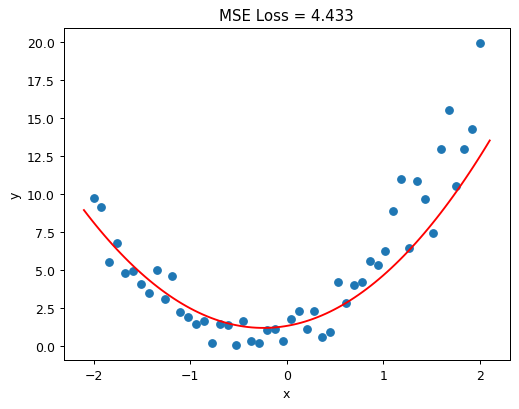

In [ ]:
w = w.detach().numpy()
print(f"Final weights: a = {w[0]:0.2}, b = {w[1]:0.2}, c = {w[2]:0.2}")

plot_quad(w[0], w[1], w[2])

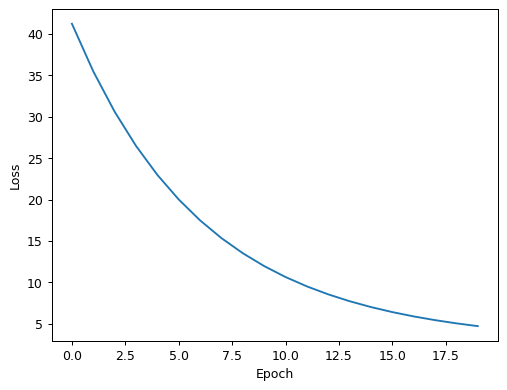

In [ ]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

### Aside: How Much Faster is PyTorch vs. Base Python?

In [ ]:
%%timeit
x = torch.tensor([0.0])
for i in range(10000):
    x = x + torch.rand(1)

In [ ]:
%%timeit
x = torch.rand(10000).sum()

## Stochastic and Mini-Batch Gradient Descent

Eventually, we'll run into two related problems:
1. With large datasets, calculating the loss will take a long time.
2. The datasets may be too large to fit in the computer's memory.

One solution is, instead of calculating the loss, we can *approximate* the loss by calculating the loss for just a single observation at a time, and then looping over the dataset. This has a major advantage: every epoch, instead of making one adjustment to the parameters, we make $N_{data}$ adjustments, massively speeding up the training process. The downside is that, as each observation is different, some of the adjustments will be in the wrong direction. Because of that randomness, this method is called **stochastic gradient descent**.

Let's implement it for our dataset and see what happens:

In [ ]:
# Get the data
x = torch.tensor(data["x"].values)
y = torch.tensor(data["y"].values)
dataset = list(zip(x,y))
dl = DataLoader(dataset, batch_size=1, shuffle=True)

# Initialize parameters
w = torch.rand(3, requires_grad=True)

# Choose hyperparameters
lr = 0.01
num_epochs = 20

# Keep track of the losses
losses = []

for e in range(num_epochs):

    losses.append(0)

    # New loop over each observation
    for step, (one_x,one_y) in enumerate(dl):
        # Calculate the predicted value
        yhat = tensor_quad(w, one_x)

        # Calculate approximate Loss
        J = mse_loss(one_y, yhat)
        # Make a running average of loss value
        losses[-1] += float(J/len(dl))

        J.backward()
        with torch.no_grad():
            w.sub_(lr*w.grad)
            w.grad.data.zero_()



Final weights: a = 2.8, b = 2.0, c = 1.0


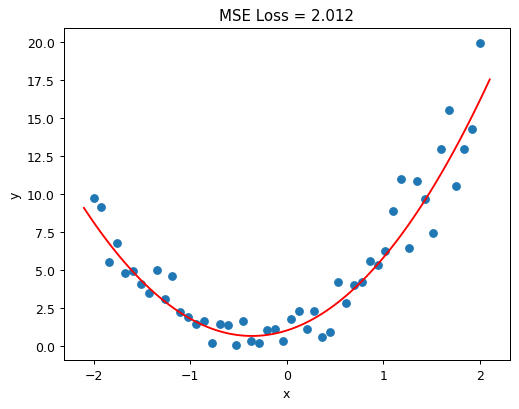

In [ ]:
w = w.detach().numpy()
print(f"Final weights: a = {w[0]:0.2}, b = {w[1]:0.2}, c = {w[2]:0.2}")

plot_quad(w[0], w[1], w[2])

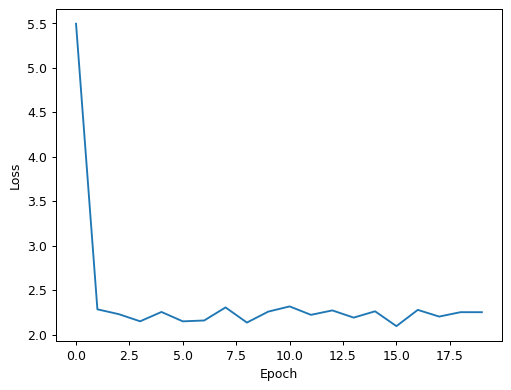

In [ ]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

This is noisier than doing every entry in the dataset at once. Perhaps using just a single observation at a time is *too* random to get a good result. Instead, let's use 20 at a time in a **minibatch**.

In [ ]:
# Get the data
x = torch.tensor(data["x"].values)
y = torch.tensor(data["y"].values)
dataset = list(zip(x,y))
dl = DataLoader(dataset, batch_size=20, shuffle=True)

# Initialize parameters
w = torch.rand(3)
w.requires_grad_()

# Choose hyperparameters
lr = 0.01
num_epochs = 20

# Keep track of the losses
losses = []

for e in range(num_epochs):

    losses.append(0)

    # New loop over each observation
    for step, (x,y) in enumerate(dl):
        # Calculate the predicted value
        yhat = tensor_quad(w, x)

        # Calculate approximate Loss
        J = mse_loss(y, yhat)
        # Make a running average of loss value
        losses[-1] += float(J/len(dl))

        J.backward()
        with torch.no_grad():
            w.sub_(lr*w.grad)
        w.grad.data.zero_()

Final weights: a = 2.9, b = 1.7, c = 1.2


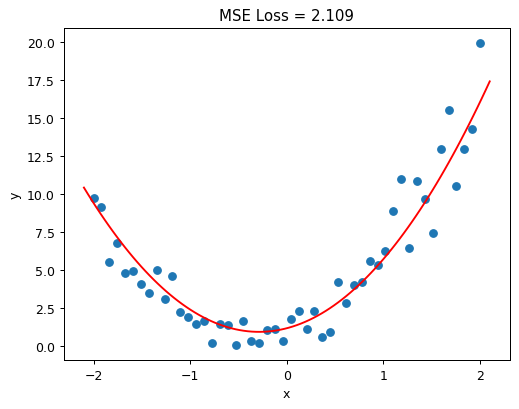

In [ ]:
x = torch.tensor(data["x"].values)
y = torch.tensor(data["y"].values)

w = w.detach().numpy()
print(f"Final weights: a = {w[0]:0.2}, b = {w[1]:0.2}, c = {w[2]:0.2}")

plot_quad(w[0], w[1], w[2])

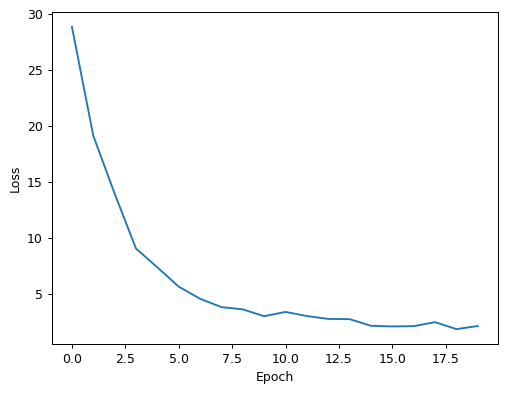

In [ ]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

## Overfitting

So far, our way of assessing fits has been to look at the fit. That's certainly important: we should always make sure that the results we get make sense, although as our datasets grow in size and our models become more than one-dimensional, it becomes difficult to assess this globally.

We also have the loss, although most loss functions aren't immediately intelligible to humans. As we go, we'll start adding new measures for how good a fit is, generally the accuracy of the model for classifiers (what % of labels they get right) or the standard deviation of the model errors for regression.

But it is always possible to make the loss, accuracy, or residuals arbitrarily small by increasing the model complexity. Consider the plots below that also fit some data. The one on the left looks good. The one on the right actually has a much lower loss, but there's something "wrong" about it. It doesn't seem to be a model that represents what we think the data are really like, but is trying to perfectly hit every point, making a function that looks needlessly wiggly or spiky. We call this **overfit.**

How do we assess overfitting, beyond looking at the model? We split our dataset up into what are called **training, validation, and testing sets.**:
* We train our model using only the training data.
* After training (and during), we can evaluate the model using the validation set. Since the model doesn't get to learn from the validation data, this is a good check on "new" data that the model doesn't know about.
* Once we're happy with the model and its performance on the validation data, we can check how it performs on the testing dataset.

One hopes it will do as well on the testing set as it did at validation. But because we may train many models and pick the one which does the best on the validation set, the model may indirectly learn about the validation set, and there may still be a bit of overfitting.

Just as a note, many datasets, APIs, and even your instructor, will sometimes erroneously refer to a validation set as a testing set.

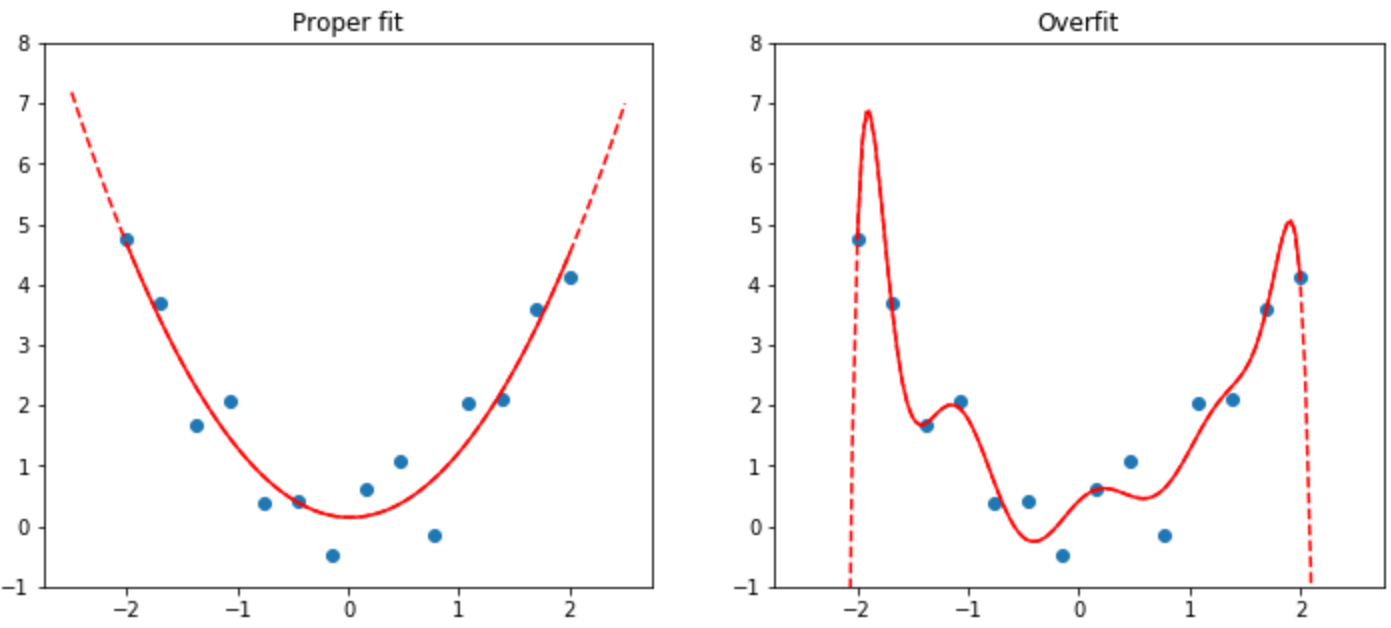

___
Technical Aside: The Bias-Variance Trade-Off

You will run into two terms in machine learning:
* **Bias.** Error on the training set.
* **Variance.** Additional error on the validation/testing sets, relative to the error on the training set.

Generally speaking, models which overfit data will have a *low bias* and *high variance*. Very simple models (for example, linear regression) may not even do a great job on the training set, but aren't overfitting and will have a *high bias* but *low variance*. Ideally, we want a model somewhere in between these extremes.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Bias_and_variance_contributing_to_total_error.svg/1280px-Bias_and_variance_contributing_to_total_error.svg.png" width="600px">

___